<span style="color:red">***Shot Adjusting is currently not supported. We are working to incorporate it into sQUlearn***</span>.

In [3]:
import numpy as np
from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.utils import QuantumInstance
import matplotlib.pyplot as plt

# takes packages files from the specified folder
import os
import sys

sys.path.insert(0, os.path.join(os.getcwd(), "..\\.."))

from squlearn.feature_map import ChebPQC
from squlearn.expectation_operator import SummedPaulis
from squlearn.qnn.qnn import QNN
from squlearn.qnn.loss import SquaredLoss, VarianceLoss
from squlearn.qnn.training import shot_adjusting_options, regression, get_variance_fac
from squlearn.optimizers import Adam

In [4]:
backend = Aer.get_backend("qasm_simulator")
QI = QuantumInstance(backend, shots=5000)

C:\Users\DKR\AppData\Local\Temp\ipykernel_19580\3953435119.py:2: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  QI = QuantumInstance(backend, shots=5000)


Define parameterized quantum circuit $Q(x,\theta)$

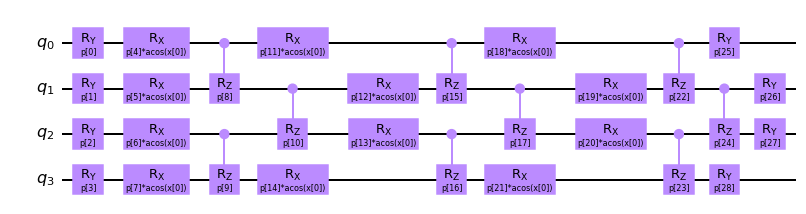

In [5]:
nqubits = 4
number_of_layers = 3
pqc = ChebPQC(nqubits, 1, num_layers=number_of_layers, closed=False)
pqc.draw()

Definition of the cost operator:
$\hat{C}(\vartheta) = \vartheta_0 \hat{I} + \sum_i \vartheta_i \hat{Z}_i $

In [6]:
cost_op = SummedPaulis(nqubits)
print(cost_op)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[3]),
 ParameterExpression(1.0*p[4])])


In [7]:
qnn = QNN(pqc, cost_op, QI)

AttributeError: 'QuantumInstance' object has no attribute 'get_shots'

Example function: $log(x)$

In [ ]:
x_space = np.arange(0.1, 0.9, 0.1)
ref_values = np.log(x_space)

np.random.seed(13)
param_ini = np.random.rand(qnn.num_parameters) * 4
param_op_ini = np.ones(nqubits + 1)

Set up automatic shot control

In [ ]:
shot_options = shot_adjusting_options(0.1, 100, 5000)
shot_options.set_l2_rstd(qnn, ref_values)

Optimization of the regression

In [ ]:
ADAM = Adam({"max_iter": 300, "lr": 0.1, "log_file": "adam_log.csv"})

res, res_op = regression(
    qnn,
    x_space,
    ref_values,
    param_ini,
    param_op_ini,
    loss=SquaredLoss(),
    variance=get_variance_fac(0.005, 0.5, 5),
    minimize=ADAM.minimize,
    shot_adjusting=shot_options,
)

theta [3.11080964 0.95016488 3.29711413 3.86299679 3.89040446 1.81379699
 2.43616985 3.10210606 2.56645338 2.88807292 0.1401461  1.19379788
 0.23404997 3.42824377 1.49141611 2.71939181 1.0251198  1.39032486
 0.03765108 1.43333513 3.79637673 0.87159604 1.27756547 3.67108954
 0.12761467 0.26033815 2.519316   3.49525377 0.03486293 1.
 1.         1.         1.         1.        ]
Current value: 56.01141605353952
Set shots for gradient evaluation to:  100  ( RSTD:  0.056 )
theta [3.11080964 0.95016488 3.29711413 3.86299679 3.89040446 1.81379699
 2.43616985 3.10210606 2.56645338 2.88807292 0.1401461  1.19379788
 0.23404997 3.42824377 1.49141611 2.71939181 1.0251198  1.39032486
 0.03765108 1.43333513 3.79637673 0.87159604 1.27756547 3.67108954
 0.12761467 0.26033815 2.519316   3.49525377 0.03486293 1.
 1.         1.         1.         1.        ]
Grad length: 66.61939259070536
grad [  2.14402146   2.08579854  -0.72040041  -2.08426847   8.18731558
   0.79203502 -12.221311    10.84563499  13.93

In [ ]:
print("Result Param:", res)
print("Result ParamOp:", res_op)

Result Param: [3.11080964 0.95016488 3.29711413 3.86299679 3.89040446 1.81379699
 2.43616985 3.10210606 2.56645338 2.88807292 0.1401461  1.19379788
 0.23404997 3.42824377 1.49141611 2.71939181 1.0251198  1.39032486
 0.03765108 1.43333513 3.79637673 0.87159604 1.27756547 3.67108954
 0.12761467 0.26033815 2.519316   3.49525377 0.03486293]
Result ParamOp: [1. 1. 1. 1. 1.]


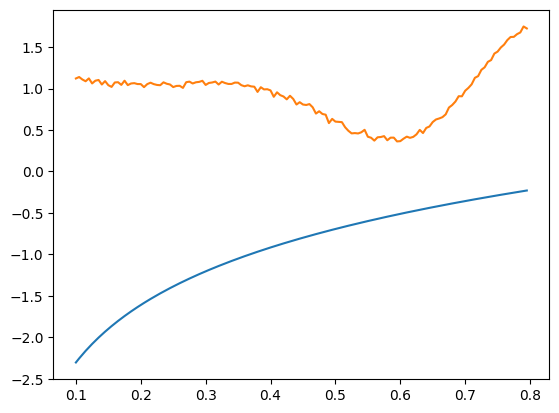

In [ ]:
x = np.arange(np.min(x_space), np.max(x_space), 0.005)
y = qnn.evaluate_f(x, res, res_op)
y_space = qnn.evaluate_f(x_space, res, res_op)
plt.plot(x, np.log(x))
plt.plot(x, y)
# plt.plot(x_space,y_space)

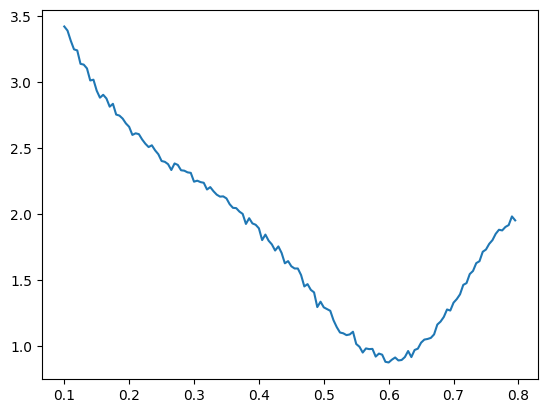

In [ ]:
plt.plot(x, np.abs(y - np.log(x)))